Здарова! Ща покажу как сделать датасет из альпийского воздуха


Нам нужно установить autodistill, foundational model(GroundingSam), обучаемую модель (yolov8) и робфлоу с супервиженом, еще всякого подключим, пригодится


In [ ]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

import supervision as sv
from tqdm.notebook import tqdm
import cv2


Нам нужна видюха, иначе долго


In [ ]:
!nvidia-smi

Wed Sep 27 18:16:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


Вставляем пути до неразмеченных картиночек, смотрим размер датасета, можно порисовать

In [ ]:
IMAGE_DIR_PATH = "/content/drive/MyDrive/CV_Itmo_course/train-smoke"

In [ ]:
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 3700


In [ ]:
IMAGE_DIR_PATH = f"/content/drive/MyDrive/CV_Itmo_course/train-smoke"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

In [ ]:
titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

Словарик с аннотациями, слева то как оно будет выглядеть на ббоксах, справа то что идет в промт большой сетке, я оставил как есть

In [ ]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "fire": "fire",
    "smoke": "smoke"
})

Давайте заведем удобные папочки под это дело, эта папка под выход большой сети, то есть размеченый готовый датасет

In [ ]:
%cd /content/drive/MyDrive/CV_Itmo_course
%mkdir foundational_output
%cd /content

/content/drive/MyDrive/CV_Itmo_course
mkdir: cannot create directory ‘foundational_output’: File exists
/content


In [ ]:
DATASET_DIR_PATH = f"/content/drive/MyDrive/CV_Itmo_course/foundational_output"

Подключаем все что нужно, у меня формат жпег, если пнг то ставь пнг

In [ ]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

Йоло нужен yaml с путями, какое счастье что за нас его сделают.

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"/content/drive/MyDrive/CV_Itmo_course/foundational_output/train/labels"
IMAGES_DIRECTORY_PATH = f"/content/drive/MyDrive/CV_Itmo_course/foundational_output/train/images"
DATA_YAML_PATH = f"/content/drive/MyDrive/CV_Itmo_course/foundational_output/data.yaml"

Вообще говоря, GSam удаляет дубликаты, вот на столько похожие картинки что половина у меня пропала, ну и ладно

In [ ]:
dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

1480

Посмотрим на результаты

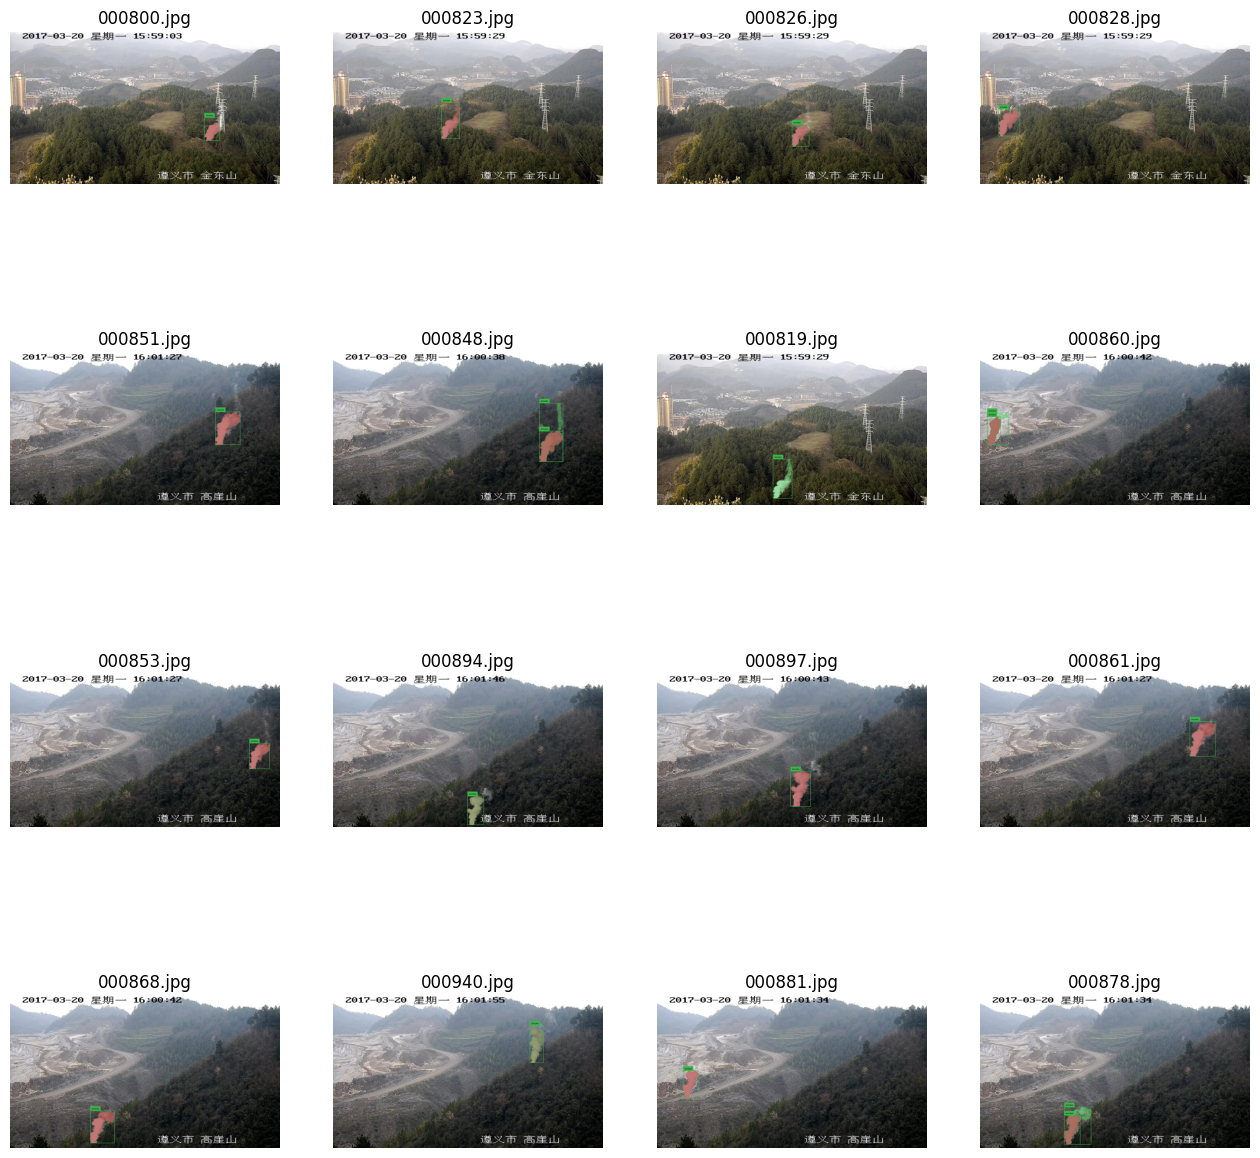

In [ ]:
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)
image_names = list(dataset.images.keys())[:SAMPLE_SIZE]


mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

Очень неплохо правда?
Следующий блокнот YoloTraining